In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [22]:
SCALER = 'MINMAX'
LAST_N = -30

In [23]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [24]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5328,2024-05-02,5064.200195,1375.000000,2299.199951,2683.649902,2676.629883
5329,2024-05-03,5127.790039,1364.640015,2299.000000,2676.629883,2734.360107
5330,2024-05-06,5180.740234,1355.050049,2321.600098,2676.629883,2734.360107
5331,2024-05-07,5187.700195,1352.170044,2316.300049,2734.360107,2737.669922
5332,2024-05-08,5187.700195,1352.170044,2316.300049,2737.669922,2737.669922


In [25]:
# df = df.drop('Date', axis=1)
df_1 = df.iloc[:LAST_N, :].copy()
df_1 = df_1.drop('Date', axis=1)
print(df_1.tail())
train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_1.columns.values
print(col_names)

              S&P     currency         gold        kospi  kospi_shift
5298  5241.529785  1330.109985  2182.399902  2754.860107  2748.560059
5299  5234.180176  1334.680054  2158.100098  2748.560059  2737.570068
5300  5218.189941  1343.599976  2174.800049  2737.570068  2757.090088
5301  5203.580078  1339.130005  2175.600098  2757.090088  2755.110107
5302  5248.490234  1343.060059  2190.600098  2755.110107  2745.820068
['S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [26]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[:-1]:
    scale_params[i] = [train_x[i].mean(), train_x[i].var(), train_x[i].max(), train_x[i].min()]
scale_params

,S&P,currency,gold,kospi
mean,2.165892e+03,1128.486683,1244.217288,1934.391483
var,1.254172e+06,12196.449063,213572.727769,289930.845817
max,5.248490e+03,1571.400024,2190.600098,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027


In [27]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[:-1]:
        train_data[i] = train_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = test_x[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi
2523,0.225361,0.344404,0.515585,0.464550
3607,0.400378,0.365171,0.500385,0.639297
798,0.162243,0.043799,0.134046,0.277257
3390,0.333597,0.417718,0.449279,0.486746
1054,0.173103,0.061208,0.230477,0.454614


In [28]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
rf = RandomForestRegressor(random_state = 0, n_jobs = -1)
model_list = [xgb, lgbm, rf]

In [29]:
# XGB
param_xgb = {"max_depth": [10, 30, 50],
              "min_child_weight" : [1, 3, 6, 10],
              "n_estimators": [100, 200, 300, 500, 1000]
              }    
# LGB                        
param_lgbm = {"learning_rate" : [0.01, 0.1, 0.2, 0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100, 300, 500, 1000],
             "n_estimators" : [100, 200, 300, 500, 1000],
             "learning_rate" : [0.01, 0.1, 0.2, 0.5]
              }
params_rf = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
params_list = [param_xgb, param_lgbm, params_rf]

In [30]:
# grid_result = pd.DataFrame(columns=['xgb', 'lgbm', 'rf'], index=['params', 'best'])

# for i in range(len(model_list)):
#     grid_model = GridSearchCV(estimator=model_list[i], param_grid=params_list[i], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
#     grid_model.fit(train_x, train_y)
#     # grid_result.iloc[0, i] = grid_model.best_params_
#     # grid_result.iloc[1, i] = grid_model.best_score_
#     print(grid_model.best_params_)
#     print(grid_model.best_score_)

# grid_result

In [31]:
rf = RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=16, min_samples_split=8, random_state=99)
rf.fit(train_data, train_y)
pred = rf.predict(test_data)

result = mean_squared_error(test_y, pred)
result

537.251192255458

kospi       0.999826
currency    0.000063
S&P         0.000063
gold        0.000048
dtype: float64


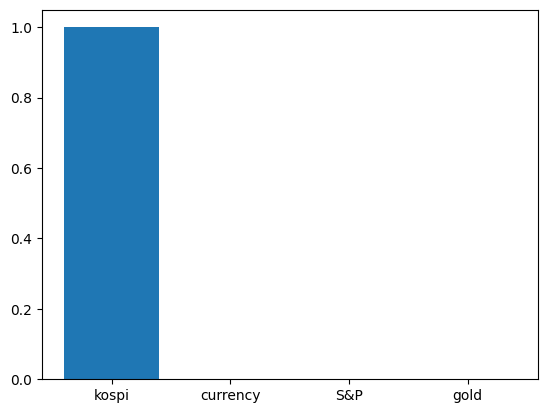

In [32]:
rf_importances = pd.Series(rf.feature_importances_, index = train_x.columns)
plt.bar(rf_importances.sort_values(ascending=False).index, rf_importances.sort_values(ascending=False))
print(rf_importances.sort_values(ascending=False))
plt.show()

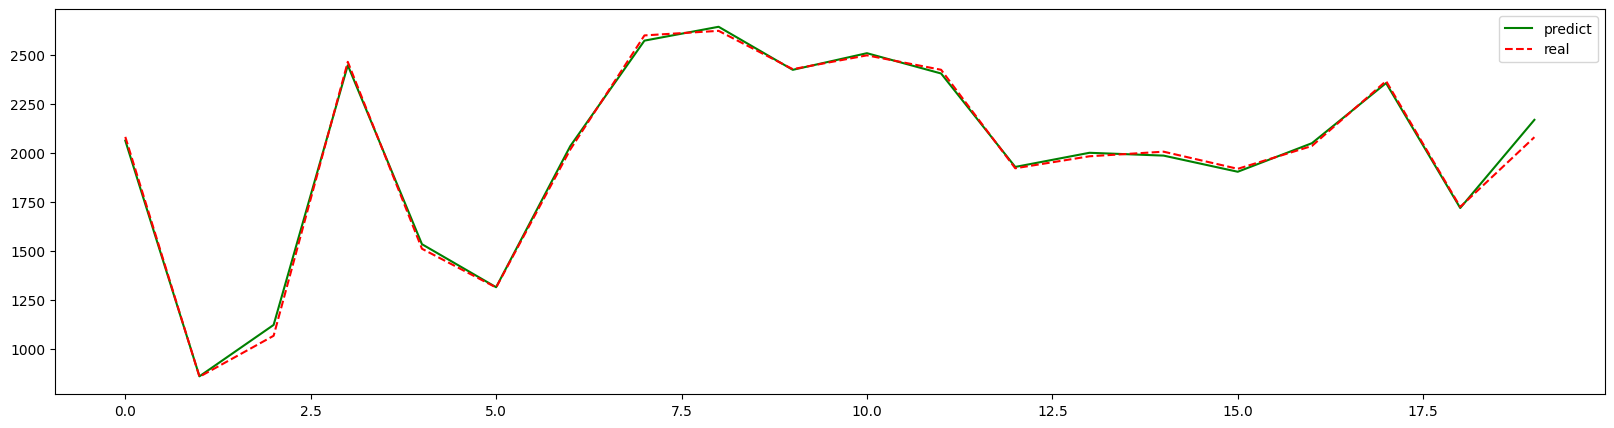

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(pred[-50:-30], 'g-', label='predict')
plt.plot(test_y[-50:-30].values, 'r--', label='real')
plt.legend()
plt.show()

In [34]:
# recent untested data prediction
for i in col_names[:-1]:
    input = df.iloc[LAST_N:, 1:].drop('kospi_shift', axis=1).apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
pred_last = rf.predict(input)
df_pred = pd.DataFrame(columns=['y', 'pred', 'diff'])
df_pred['pred'] = pred_last
df_pred['y'] = df.iloc[LAST_N:, -1:].values
df_pred['diff'] = df_pred['y'] - df_pred['pred']
df_pred

,y,pred,diff
0,2746.629883,2743.069862,3.560020
1,2747.860107,2743.290239,4.569868
2,2753.159912,2743.290239,9.869673
3,2706.969971,2743.290239,-36.320268
4,2742.000000,2703.451480,38.548520
5,2714.209961,2742.137397,-27.927436
6,2717.649902,2705.480851,12.169051
7,2705.159912,2705.480851,-0.320939
8,2706.959961,2702.762292,4.197669
9,2706.959961,2702.762292,4.197669


In [35]:
df.iloc[LAST_N:, 0:1].values.reshape(-1)

array(['2024-03-28', '2024-03-29', '2024-04-01', '2024-04-02',
       '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08',
       '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12',
       '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
       '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
       '2024-04-25', '2024-04-26', '2024-04-29', '2024-04-30',
       '2024-05-01', '2024-05-02', '2024-05-03', '2024-05-06',
       '2024-05-07', '2024-05-08'], dtype=object)

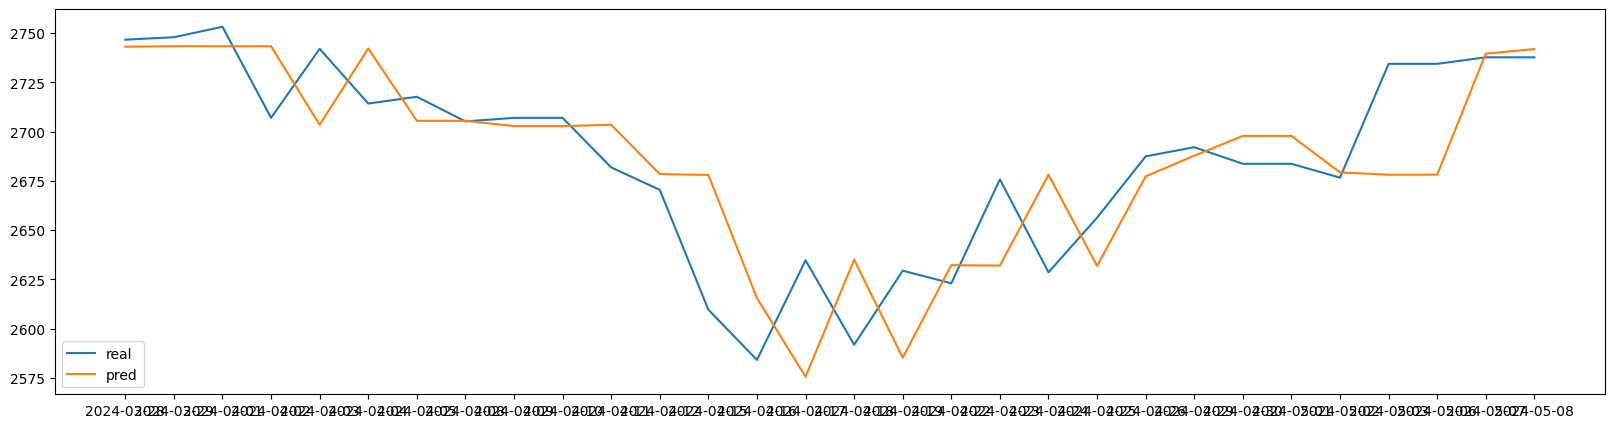

In [36]:
# recent untested data prediction
plt.figure(figsize=(20, 5))
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['y'], label='real')
plt.plot(df.iloc[LAST_N:, 0:1].values.reshape(-1), df_pred['pred'], label='pred')
plt.legend()
plt.show()

In [37]:
df_test_result = pd.merge(test_y, df['Date'], left_index=True, right_index=True, how='left')
df_test_result['pred'] = pred
df_test_result = df_test_result[['Date', 'pred', 'kospi_shift']]
df_test_result['diff'] = df_test_result['pred'] - df_test_result['kospi_shift']
df_test_result = df_test_result.sort_index(ascending=True)
df_test_result

,Date,pred,kospi_shift,diff
2,2003-12-03,807.161681,805.130005,2.031676
5,2003-12-08,791.340424,787.349976,3.990448
26,2004-01-06,823.338702,827.070007,-3.731305
31,2004-01-13,852.051907,849.619995,2.431912
34,2004-01-16,859.135985,856.799988,2.335997
...,...,...,...,...
5267,2024-02-07,2619.944513,2620.320068,-0.375555
5272,2024-02-14,2635.255580,2613.800049,21.455532
5274,2024-02-16,2654.151234,2680.260010,-26.108775
5277,2024-02-21,2659.209686,2664.270020,-5.060334


In [38]:
(np.square(df_test_result['diff']).sum()/len(df_test_result))**0.5

23.178679691808547

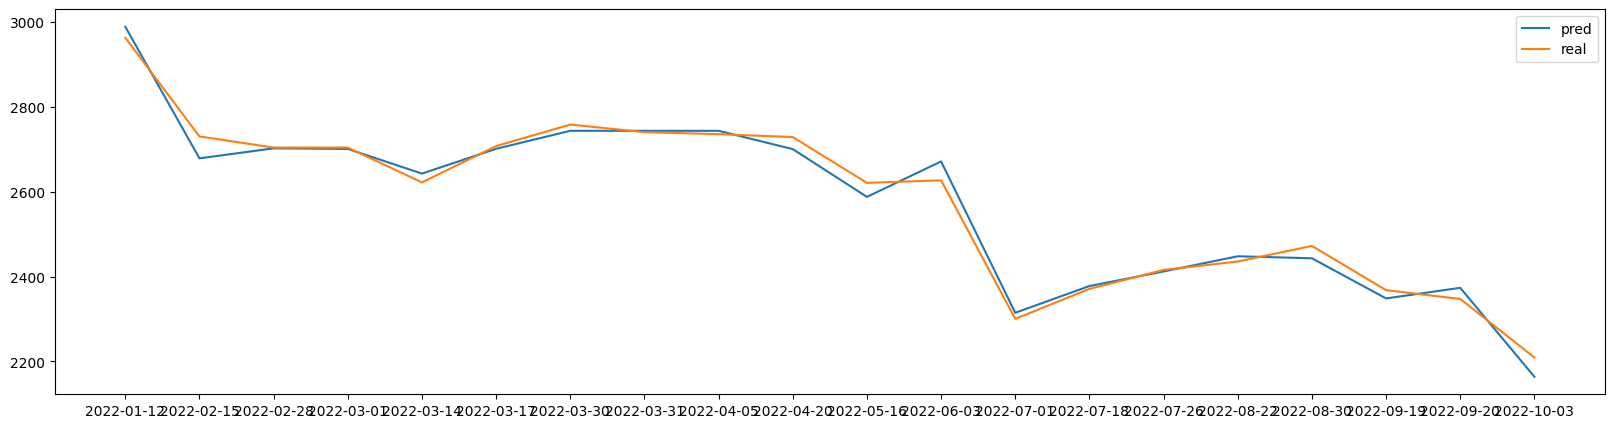

In [39]:
start = -60
end = -40
plt.figure(figsize=(20, 5))
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 1:2].values, label='pred')
plt.plot(df_test_result.iloc[start:end, 0:1].values.reshape(-1), df_test_result.iloc[start:end, 2:3].values, label='real')
plt.legend()
plt.show()

In [40]:
mse = mean_squared_error(df_test_result['kospi_shift'], df_test_result['pred'])
mape = mean_absolute_percentage_error(df_test_result['kospi_shift'], df_test_result['pred'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 537.2512, MAPE: 0.0092
